In [ ]:
# http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/
# https://www.kaggle.com/uciml/sms-spam-collection-dataset?select=spam.csv

In [1]:
import numpy as np
import pandas as pd
import nltk
import spacy
import math
import copy
import seaborn as sns
import matplotlib.pyplot as plt
nlp = spacy.load('en_core_web_trf')

## Read & Preprocess Data set

In [3]:
# read and delete rows with NaN
df = pd.read_csv("spam.csv")
print(len(df))

5572


In [4]:
# rename and delete trivial columns and rows with NaN
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)
df.rename(columns = {'v1': 'label', 'v2': 'text'}, inplace = True)
display(df.head())
df.dropna(inplace = True)
print(len(df))

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


5572


In [5]:
# https://datascienceparichay.com/article/pandas-groupby-count-of-rows-in-each-group/ 
# ham and spam info
df.groupby('label').count()

,text
label,
ham,4825
spam,747


In [6]:
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
# seperate into train and test
trainDF=df.sample(frac=0.8,random_state=200) #random state is a seed value
testDF=df.drop(trainDF.index)
trainDF.reset_index(drop = True, inplace = True)
testDF.reset_index(drop = True, inplace = True)
display(testDF.shape)
display(trainDF.shape)

(1114, 2)

(4458, 2)

In [7]:
trainDF.groupby('label').count()

,text
label,
ham,3870
spam,588


In [8]:
testDF.groupby('label').count()

,text
label,
ham,955
spam,159


## Process with Spacy

In [82]:
# https://stackoverflow.com/questions/41170726/add-remove-custom-stop-words-with-spacy
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

## NER Tags 
Tags are accessible through the `.label_` property of an entity.
<table>
<tr><th>TYPE</th><th>DESCRIPTION</th><th>EXAMPLE</th></tr>
<tr><td>`PERSON`</td><td>People, including fictional.</td><td>*Fred Flintstone*</td></tr>
<tr><td>`NORP`</td><td>Nationalities or religious or political groups.</td><td>*The Republican Party*</td></tr>
<tr><td>`FAC`</td><td>Buildings, airports, highways, bridges, etc.</td><td>*Logan International Airport, The Golden Gate*</td></tr>
<tr><td>`ORG`</td><td>Companies, agencies, institutions, etc.</td><td>*Microsoft, FBI, MIT*</td></tr>
<tr><td>`GPE`</td><td>Countries, cities, states.</td><td>*France, UAR, Chicago, Idaho*</td></tr>
<tr><td>`LOC`</td><td>Non-GPE locations, mountain ranges, bodies of water.</td><td>*Europe, Nile River, Midwest*</td></tr>
<tr><td>`PRODUCT`</td><td>Objects, vehicles, foods, etc. (Not services.)</td><td>*Formula 1*</td></tr>
<tr><td>`EVENT`</td><td>Named hurricanes, battles, wars, sports events, etc.</td><td>*Olympic Games*</td></tr>
<tr><td>`WORK_OF_ART`</td><td>Titles of books, songs, etc.</td><td>*The Mona Lisa*</td></tr>
<tr><td>`LAW`</td><td>Named documents made into laws.</td><td>*Roe v. Wade*</td></tr>
<tr><td>`LANGUAGE`</td><td>Any named language.</td><td>*English*</td></tr>
<tr><td>`DATE`</td><td>Absolute or relative dates or periods.</td><td>*20 July 1969*</td></tr>
<tr><td>`TIME`</td><td>Times smaller than a day.</td><td>*Four hours*</td></tr>
<tr><td>`PERCENT`</td><td>Percentage, including "%".</td><td>*Eighty percent*</td></tr>
<tr><td>`MONEY`</td><td>Monetary values, including unit.</td><td>*Twenty Cents*</td></tr>
<tr><td>`QUANTITY`</td><td>Measurements, as of weight or distance.</td><td>*Several kilometers, 55kg*</td></tr>
<tr><td>`ORDINAL`</td><td>"first", "second", etc.</td><td>*9th, Ninth*</td></tr>
<tr><td>`CARDINAL`</td><td>Numerals that do not fall under another type.</td><td>*2, Two, Fifty-two*</td></tr>
</table>

https://universaldependencies.org/docs/u/pos/ 

In [9]:
ham_freq_words = {}
spam_freq_words = {}
ham_ne = {}
spam_ne = {}
ham_pos = {}
spam_pos = {}
# tokenize each review and add to corrsponding list
for i in range(0, len(trainDF)):
    doc = nlp(trainDF.loc[i]['text'])
    token_lemma_cleaned = [token.lemma_ for token in doc if not token.is_stop]
    token_lemma_cleaned = [token.lower() for token in token_lemma_cleaned if token.isalpha()]
    # for word freq, we use lemmatized non stop and alpha word
    # for ner and postag, we use all the doc.ents and doc
    if (trainDF.loc[i]['label'] == 'ham'):
        for token in token_lemma_cleaned:
            ham_freq_words[token] = ham_freq_words.get(token, 0) + 1
        for ent in doc.ents:
            ham_ne[ent.label_] = ham_ne.get(ent.label_,0) + 1
        for token in doc:
            if token.pos_ not in ham_pos:
                ham_pos[token.pos_] = {}
            ham_pos[token.pos_][token.lemma_] = ham_pos[token.pos_].get(token.lemma_, 0) + 1
    else: # spam
        for token in token_lemma_cleaned:
            spam_freq_words[token] = spam_freq_words.get(token, 0) + 1
        for ent in doc.ents:
            spam_ne[ent.label_] = spam_ne.get(ent.label_,0) + 1
        for token in doc:
            if token.pos_ not in spam_pos:
                spam_pos[token.pos_] = {}
            spam_pos[token.pos_][token.lemma_] = spam_pos[token.pos_].get(token.lemma_, 0) + 1

In [12]:
# sort and normalize by maximum for word freq and name entity freq
sorted_ham_freq = dict(sorted(ham_freq_words.items(), key = lambda item: item[1], reverse = True))
sorted_spam_freq = dict(sorted(spam_freq_words.items(), key = lambda item: item[1], reverse = True))
ham_freq_max = max(sorted_ham_freq.values())
spam_freq_max = max(sorted_spam_freq.values())
weighted_freq_ham = {word: count/ham_freq_max for (word, count) in sorted_ham_freq.items()}
weighted_freq_spam = {word: count/spam_freq_max for (word, count) in sorted_spam_freq.items()}


sorted_ham_ne = dict(sorted(ham_ne.items(), key = lambda item: item[1], reverse = True))
sorted_spam_ne = dict(sorted(spam_ne.items(), key = lambda item: item[1], reverse = True))
ham_ne_max = max(sorted_ham_ne.values())
spam_ne_max = max(sorted_spam_ne.values())
weighted_ne_ham = {word: count/ham_ne_max for (word, count) in sorted_ham_ne.items()}
weighted_ne_spam = {word: count/spam_ne_max for (word, count) in sorted_spam_ne.items()}

In [13]:
# sort POS nested dictionary 
ham_copy = copy.deepcopy(ham_pos)
spam_copy = copy.deepcopy(spam_pos)

for key in ham_copy.keys():
    smallDict = ham_copy[key]
    smallDict = dict(sorted(smallDict.items(), key = lambda item: item[1], reverse = True))
    ham_pos[key] = smallDict
    
for key in spam_copy.keys():
    smallDict = spam_copy[key]
    smallDict = dict(sorted(smallDict.items(), key = lambda item: item[1], reverse = True))
    spam_pos[key] = smallDict

## Insights

In [14]:
# sorted common words in ham
weighted_freq_ham

{'u': 1.0,
 'come': 0.33025099075297226,
 'nt': 0.31836195508586523,
 'ok': 0.2985468956406869,
 'go': 0.2892998678996037,
 'know': 0.27212681638044917,
 'good': 0.2668428005284016,
 'ur': 0.261558784676354,
 'get': 0.2523117569352708,
 'like': 0.24966974900924702,
 'want': 0.2404227212681638,
 'day': 0.23778071334214002,
 'love': 0.23249669749009247,
 'time': 0.22324966974900926,
 'send': 0.21268163804491413,
 'need': 0.19947159841479525,
 'think': 0.19815059445178335,
 'tell': 0.190224570673712,
 'lor': 0.17701453104359313,
 'home': 0.17305151915455746,
 'sorry': 0.15852047556142668,
 'r': 0.15587846763540292,
 'da': 0.15191545574636725,
 'n': 0.14398943196829592,
 'later': 0.14002642007926025,
 'today': 0.13870541611624834,
 'say': 0.13870541611624834,
 'work': 0.13738441215323646,
 'thing': 0.130779392338177,
 'ask': 0.12945838837516513,
 'meet': 0.12417437252311757,
 's': 0.12285336856010567,
 'wat': 0.1215323645970938,
 'hope': 0.11889035667107001,
 'hi': 0.11889035667107001,
 'm

In [15]:
# sorted common words in spam
weighted_freq_spam

{'free': 1.0,
 'txt': 0.7857142857142857,
 'ur': 0.7023809523809523,
 'u': 0.6547619047619048,
 'win': 0.6428571428571429,
 'mobile': 0.6190476190476191,
 'text': 0.5773809523809523,
 'reply': 0.5119047619047619,
 'stop': 0.5119047619047619,
 'claim': 0.48214285714285715,
 'tone': 0.4107142857142857,
 'prize': 0.40476190476190477,
 'min': 0.38095238095238093,
 'send': 0.3630952380952381,
 'nokia': 0.34523809523809523,
 'new': 0.3392857142857143,
 'cash': 0.3392857142857143,
 'service': 0.31547619047619047,
 'week': 0.30952380952380953,
 'contact': 0.30357142857142855,
 'urgent': 0.2916666666666667,
 'award': 0.25595238095238093,
 'phone': 0.25,
 'message': 0.23809523809523808,
 'msg': 0.2261904761904762,
 'customer': 0.21428571428571427,
 'try': 0.19642857142857142,
 'chat': 0.19642857142857142,
 'offer': 0.19047619047619047,
 'draw': 0.18452380952380953,
 'late': 0.17857142857142858,
 'wk': 0.17261904761904762,
 'video': 0.16666666666666666,
 'receive': 0.16666666666666666,
 'cost': 0

In [16]:
# sorted ne in ham
weighted_ne_ham  

{'PERSON': 1.0,
 'DATE': 0.9187620889748549,
 'TIME': 0.5880077369439072,
 'CARDINAL': 0.3771760154738878,
 'GPE': 0.2727272727272727,
 'ORDINAL': 0.1644100580270793,
 'ORG': 0.15860735009671179,
 'EVENT': 0.06769825918762089,
 'NORP': 0.058027079303675046,
 'MONEY': 0.03288201160541586,
 'QUANTITY': 0.03288201160541586,
 'LOC': 0.030947775628626693,
 'WORK_OF_ART': 0.027079303675048357,
 'FAC': 0.02321083172147002,
 'PRODUCT': 0.01160541586073501,
 'PERCENT': 0.0038684719535783366,
 'LANGUAGE': 0.0038684719535783366}

In [17]:
# sorted ne in spam
weighted_ne_spam

{'CARDINAL': 1.0,
 'DATE': 0.8448979591836735,
 'MONEY': 0.7918367346938775,
 'ORG': 0.6816326530612244,
 'TIME': 0.23265306122448978,
 'GPE': 0.17959183673469387,
 'PERSON': 0.17142857142857143,
 'PRODUCT': 0.1346938775510204,
 'ORDINAL': 0.08163265306122448,
 'EVENT': 0.05714285714285714,
 'QUANTITY': 0.04081632653061224,
 'WORK_OF_ART': 0.0326530612244898,
 'FAC': 0.012244897959183673,
 'NORP': 0.012244897959183673,
 'PERCENT': 0.00816326530612245,
 'LOC': 0.004081632653061225}

In [18]:
ham_pos

{'INTJ': {'ok': 167,
  'no': 93,
  'hi': 89,
  'oh': 84,
  'hey': 80,
  'sorry': 76,
  'yeah': 63,
  'please': 62,
  'yes': 53,
  'lol': 47,
  'haha': 43,
  'like': 42,
  'well': 40,
  'yup': 35,
  'hello': 32,
  'pls': 30,
  'ah': 26,
  'yo': 24,
  'leh': 18,
  'aight': 18,
  'da': 17,
  'huh': 17,
  'dunno': 17,
  'ha': 15,
  'cool': 14,
  'nope': 14,
  'k': 13,
  'dear': 13,
  'ya': 13,
  'alright': 12,
  'okay': 12,
  'anyway': 11,
  'hmm': 11,
  'okie': 11,
  'eh': 10,
  'yep': 10,
  'thanks': 10,
  'now': 10,
  'ugh': 9,
  'hee': 9,
  'fuck': 9,
  'plz': 9,
  'nah': 9,
  'mah': 9,
  'sure': 9,
  'rite': 8,
  'wow': 8,
  'cos': 8,
  'thanx': 8,
  'mm': 8,
  'ho': 7,
  'omg': 7,
  'xxx': 7,
  'hmmm': 6,
  'o': 6,
  '\\hey': 6,
  'y': 6,
  'meh': 6,
  'tick': 6,
  'boo': 5,
  'shit': 5,
  'dun': 5,
  'ur': 5,
  'goodnight': 5,
  'oops': 5,
  'man': 5,
  '...': 4,
  'er': 4,
  'lmao': 4,
  'goodmorning': 4,
  'bye': 4,
  'anyways': 4,
  'wah': 4,
  'prob': 4,
  'yay': 4,
  '\\hi': 4,

In [19]:
spam_pos

{'VERB': {'call': 261,
  'win': 107,
  'get': 72,
  'send': 61,
  'text': 54,
  'reply': 54,
  'have': 54,
  'claim': 49,
  'stop': 48,
  'be': 45,
  'contact': 42,
  'try': 32,
  'receive': 28,
  'find': 27,
  'show': 26,
  'txt': 26,
  'go': 25,
  'award': 25,
  'want': 24,
  'apply': 23,
  'await': 23,
  'know': 22,
  'guarantee': 21,
  'collect': 20,
  'select': 19,
  'wait': 17,
  'join': 16,
  'take': 16,
  'tell': 16,
  'cost': 15,
  'see': 15,
  'enter': 14,
  'play': 13,
  'expire': 13,
  'unsubscribe': 13,
  'think': 13,
  'end': 12,
  'make': 12,
  'do': 12,
  'opt': 11,
  'enjoy': 11,
  'look': 11,
  'start': 10,
  'choose': 10,
  'use': 9,
  'follow': 9,
  'update': 9,
  'keep': 8,
  'invite': 8,
  'r*reveal': 8,
  'miss': 8,
  'speak': 7,
  'value': 7,
  'r': 7,
  'fancy': 7,
  'offer': 6,
  'meet': 6,
  'visit': 6,
  'maximize': 6,
  'charge': 6,
  'like': 6,
  'help': 6,
  'chat': 6,
  'guess': 6,
  'come': 6,
  'register': 5,
  'quote': 5,
  'activate': 5,
  'book': 5,

In [20]:
# pos for ham
for key, smallDict in ham_pos.items():
    print(key, list(smallDict.keys())[0])

INTJ ok
PUNCT .
PRON I
AUX be
PART to
NOUN day
VERB be
ADV how
SPACE  
X &
ADJ good
CCONJ and
ADP in
DET the
PROPN lor
NUM 2
SCONJ if
SYM /


In [21]:
# pos for spam
for key, smallDict in spam_pos.items():
    print(key, list(smallDict.keys())[0])

VERB call
PRON you
PROPN Nokia
PART to
NOUN txt
ADP to
CCONJ or
PUNCT .
NUM 2
X /
AUX be
DET a
ADJ free
ADV now
SYM /
SCONJ if
INTJ please


## plot distribution

In [23]:
# first, calculate the diffScore and diffNE using the dictionary we got
def getDiffScore(text):
    hamScore = 0;
    spamScore = 0;
    doc = nlp(text)
    token_lemma_cleaned = [token.lemma_ for token in doc if not token.is_stop]
    token_lemma_cleaned = [token.lower() for token in token_lemma_cleaned if token.isalpha()]
    
    for token in token_lemma_cleaned:
        hamScore += weighted_freq_ham.get(token, 0)
        spamScore += weighted_freq_spam.get(token, 0)
    return hamScore - spamScore
    
    
def getDiffNE(text):
    hamScore = 0;
    spamScore = 0;
    doc = nlp(text)
    
    for ent in doc.ents:
        hamScore += weighted_ne_ham.get(ent.label_, 0)
        spamScore += weighted_ne_spam.get(ent.label_, 0)
    return hamScore - spamScore

In [24]:
trainDF['diffScore'] = trainDF['text'].apply(lambda text: getDiffScore(text))

In [25]:
trainDF['diffNE'] = trainDF['text'].apply(lambda text: getDiffNE(text))

In [54]:
nltk.download('vader_lexicon')
# lifted from inclass example
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zdszy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [55]:
trainDF['vader_compound'] = trainDF['text'].apply(lambda text: sid.polarity_scores(text)['compound'])
trainDF.head()

,label,text,diffScore,diffNE,vader_compound
0,ham,No. It's not pride. I'm almost &lt;#&gt; yea...,0.277828,0.000000,-0.5000
1,ham,"God picked up a flower and dippeditinaDEW, lov...",0.434799,0.000000,0.8816
2,ham,Hmmm...k...but i want to change the field quic...,0.078136,0.000000,0.0772
3,ham,"Sorry, I'll call later",0.286642,0.000000,-0.0772
4,spam,Collect your VALENTINE'S weekend to PARIS inc ...,-1.265372,-1.737804,0.3382


In [56]:
hamSampleDF = trainDF.loc[(trainDF['label'] == 'ham')].sample(frac=0.5, replace=True, random_state=13)

In [57]:
spamSampleDF = trainDF.loc[(trainDF['label'] == 'spam')].sample(frac=0.5, replace=True, random_state=13)

In [58]:
hamSampleDF['diffScore'].describe()

count    1935.000000
mean        0.264912
std         0.391285
min        -1.874953
25%         0.046212
50%         0.204221
75%         0.428851
max         2.529927
Name: diffScore, dtype: float64

In [59]:
spamSampleDF['diffScore'].describe()

count    294.000000
mean      -1.720857
std        1.212382
min       -5.675379
25%       -2.628012
50%       -1.585869
75%       -0.883162
max        0.645468
Name: diffScore, dtype: float64

D:\Anaconda\lib\site-packages\seaborn\distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
D:\Anaconda\lib\site-packages\seaborn\distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(


(-5.0, 1.5)

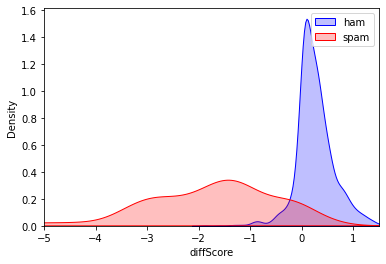

In [60]:
sns.kdeplot(hamSampleDF.loc[(hamSampleDF['label'] == 'ham'),
            'diffScore'], color='b', shade=True, Label='ham')
  
sns.kdeplot(spamSampleDF.loc[(spamSampleDF['label'] == 'spam'), 
            'diffScore'], color='r', shade=True, Label='spam')
plt.legend()
plt.xlim(-5, 1.5) # -0.24

In [61]:
hamSampleDF['diffNE'].describe()

count    1935.000000
mean        0.118346
std         0.387220
min        -3.948273
25%         0.000000
50%         0.000000
75%         0.073864
max         3.314286
Name: diffNE, dtype: float64

In [62]:
spamSampleDF['diffNE'].describe()

count    294.000000
mean      -0.634609
std        0.885836
min       -4.145336
25%       -1.162555
50%       -0.462128
75%        0.000000
max        0.913401
Name: diffNE, dtype: float64

D:\Anaconda\lib\site-packages\seaborn\distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
D:\Anaconda\lib\site-packages\seaborn\distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(


(-3.0, 1.0)

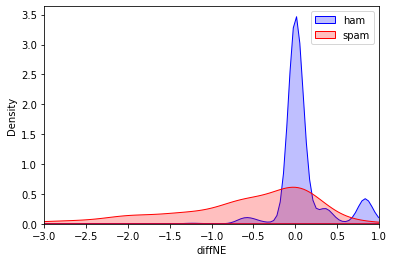

In [63]:
sns.kdeplot(hamSampleDF.loc[(hamSampleDF['label'] == 'ham'),
            'diffNE'], color='b', shade=True, Label='ham')
  
sns.kdeplot(spamSampleDF.loc[(spamSampleDF['label'] == 'spam'), 
            'diffNE'], color='r', shade=True, Label='spam')
plt.legend()
plt.xlim(-3, 1) # -0.16

In [64]:
hamSampleDF['vader_compound'].describe()

count    1935.000000
mean        0.147643
std         0.395821
min        -0.943700
25%         0.000000
50%         0.000000
75%         0.458800
max         0.980800
Name: vader_compound, dtype: float64

In [65]:
spamSampleDF['vader_compound'].describe()

count    294.000000
mean       0.447618
std        0.490430
min       -0.762600
25%        0.000000
50%        0.651400
75%        0.855300
max        0.975300
Name: vader_compound, dtype: float64

D:\Anaconda\lib\site-packages\seaborn\distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
D:\Anaconda\lib\site-packages\seaborn\distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(


(-1.0, 1.5)

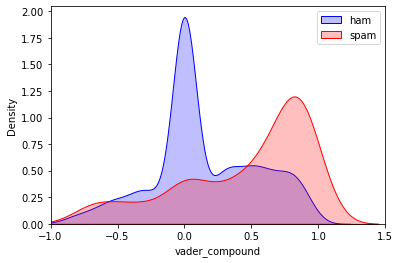

In [66]:
sns.kdeplot(hamSampleDF.loc[(hamSampleDF['label'] == 'ham'),
            'vader_compound'], color='b', shade=True, Label='ham')
  
sns.kdeplot(spamSampleDF.loc[(spamSampleDF['label'] == 'spam'), 
            'vader_compound'], color='r', shade=True, Label='spam')
plt.legend()
plt.xlim(-1,1.5) # 0.46

## random forest classfier

In [67]:
# https://www.youtube.com/watch?v=eM4uJ6XGnSM&t=1439s&ab_channel=Simplilearn 

In [68]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

# Set random seed
np.random.seed(0)

In [69]:
trainDF.columns

Index(['label', 'text', 'diffScore', 'diffNE', 'vader_compound'], dtype='object')

In [70]:
features = trainDF.columns[[2, 3, 4]]
features

Index(['diffScore', 'diffNE', 'vader_compound'], dtype='object')

In [71]:
# convert
codes, labels = pd.factorize(trainDF['label'])
print(codes)
print(labels)

[0 0 0 ... 0 0 0]
Index(['ham', 'spam'], dtype='object')


In [72]:
clf = RandomForestClassifier(n_jobs = 2, random_state = 0)
clf.fit(trainDF[features], codes)

RandomForestClassifier(n_jobs=2, random_state=0)

## try Random Forest on testing set

In [73]:
# diffScore and diffNE added to testDF, as well as sentiment score using vader
testDF['diffScore'] = testDF['text'].apply(lambda text: getDiffScore(text))
testDF['diffNE'] = testDF['text'].apply(lambda text: getDiffNE(text))
testDF['vader_compound'] = testDF['text'].apply(lambda text: sid.polarity_scores(text)['compound'])

In [74]:
testDF.head(10)

,label,text,diffScore,diffNE,vader_compound,RFprediction,CustomPrediction
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,-3.631204,0.084420,0.7964,spam,spam
1,ham,Eh u remember how 2 spell his name... Yes i di...,0.456714,0.000000,0.4019,ham,ham
2,ham,Fine if that��s the way u feel. That��s the wa...,0.858936,0.000000,0.2023,ham,ham
3,ham,I see the letter B on my car,0.055404,0.000000,0.0000,ham,ham
4,ham,"Yeah hopefully, if tyler can't do it I could m...",0.263501,0.000000,0.5994,ham,ham
5,ham,"Sorry, I'll call later in meeting.",0.306457,0.000000,-0.0772,ham,ham
6,spam,"As a valued customer, I am pleased to advise y...",-1.189187,0.000000,0.9201,spam,spam
7,spam,Urgent UR awarded a complimentary trip to Euro...,-2.275571,-0.523025,0.7506,spam,spam
8,ham,HI BABE IM AT HOME NOW WANNA DO SOMETHING? XX,0.239518,0.000000,0.0000,ham,ham
9,ham,Thats cool. i am a gentleman and will treat yo...,0.161115,0.000000,0.8689,ham,ham


In [75]:
RFprediction = labels[clf.predict(testDF[features])]
RFprediction

Index(['spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham',
       ...
       'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham'],
      dtype='object', length=1114)

In [76]:
testDF['RFprediction'] = RFprediction

In [77]:
testDF.head(10)

,label,text,diffScore,diffNE,vader_compound,RFprediction,CustomPrediction
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,-3.631204,0.084420,0.7964,spam,spam
1,ham,Eh u remember how 2 spell his name... Yes i di...,0.456714,0.000000,0.4019,ham,ham
2,ham,Fine if that��s the way u feel. That��s the wa...,0.858936,0.000000,0.2023,ham,ham
3,ham,I see the letter B on my car,0.055404,0.000000,0.0000,ham,ham
4,ham,"Yeah hopefully, if tyler can't do it I could m...",0.263501,0.000000,0.5994,ham,ham
5,ham,"Sorry, I'll call later in meeting.",0.306457,0.000000,-0.0772,ham,ham
6,spam,"As a valued customer, I am pleased to advise y...",-1.189187,0.000000,0.9201,spam,spam
7,spam,Urgent UR awarded a complimentary trip to Euro...,-2.275571,-0.523025,0.7506,spam,spam
8,ham,HI BABE IM AT HOME NOW WANNA DO SOMETHING? XX,0.239518,0.000000,0.0000,ham,ham
9,ham,Thats cool. i am a gentleman and will treat yo...,0.161115,0.000000,0.8689,ham,ham


In [78]:
# modified from inclass example
# get accuracy
correct_prediction = 0

for i in range(0, len(testDF)):
    if testDF.loc[i]['RFprediction'] == testDF.loc[i]['label']:
        correct_prediction += 1

print(correct_prediction)  
accuracy = correct_prediction / len(testDF) 
print(accuracy)

1085
0.973967684021544


### Build my own predictor

In [79]:
def getCustomPrediction(diffScore):
    if diffScore > -0.25:
        return 'ham'
    return 'spam'

In [80]:
testDF['CustomPrediction'] = testDF['diffScore'].apply(lambda diffScore: getCustomPrediction(diffScore))

In [81]:
# get accuracy
correct_prediction = 0

for i in range(0, len(testDF)):
    if testDF.loc[i]['CustomPrediction'] == testDF.loc[i]['label']:
        correct_prediction += 1

print(correct_prediction)  
accuracy = correct_prediction / len(testDF) 
print(accuracy)

1047
0.9398563734290843
